In [2]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn import GELU
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import bisect

In [3]:
# Step 1: Define the Neural Network Architecture

# original: all fully connected 
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.GELU(),
            nn.Linear(128, 128),
            nn.GELU(),
            nn.Linear(128, output_size),
        )

    def forward(self, x):
        return self.net(x)
    
# updated model with conv1d layers
class PairedDualConvNet(nn.Module):
    def __init__(self, input_dim=101, output_dim=100, group_size=7, num_groups=7):
        super().__init__()

        C1 = 32
        C2 = 32

        self.num_groups = num_groups
        self.group_size = group_size
        self.num_pairs = num_groups * group_size  # 49
        self.used_for_pairing = self.num_pairs * 2
        self.leftover_dim = input_dim - self.used_for_pairing
        self.pair_output = 8

        # Stage 1: pairwise linear 
        self.pair_fc1 = nn.Linear(2, C1)  # like conv kernel_size=2
        self.pair_fc2 = nn.Linear(C1, self.pair_output)  # like conv kernel_size=1

        # Stage 2: linear over flattened group
        self.group_fcA = nn.Linear(group_size * self.pair_output, C2)
        self.group_fcB = nn.Linear(num_groups * self.pair_output, C2)
        # MLP input = 56 + 56 + leftover(3) = 115
        mlp_in = (num_groups * C2) + (group_size * C2) + self.leftover_dim

        self.fc1 = nn.Linear(mlp_in, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, 256)
        self.fc7 = nn.Linear(256, output_dim)

    def forward(self, x):
        B = x.size(0)

        x_pairs = x[:, :self.used_for_pairing].view(B, self.num_pairs, 2)  # (B,49,2)
        x_left = x[:, self.used_for_pairing:]  # (B,3)

        # Stage 1
        p = F.gelu(self.pair_fc1(x_pairs))     # (B,49,8)
        p = F.gelu(self.pair_fc2(p))           # (B,49,2)

        # Stage 2A: groups
        p_groups = p.view(B, self.num_groups, self.group_size * self.pair_output)  # (B,7,14)
        a = F.gelu(self.group_fcA(p_groups))                      # (B,7,8)
        a_flat = a.view(B, -1)                                     # (B,56)

        # Stage 2B: threads
        p_threads = p.view(B, self.num_groups, self.group_size, self.pair_output)   # (B,7,7,2)
        p_threads = p_threads.permute(0,2,1,3).contiguous()           # (B,7,7,2)
        p_threads = p_threads.view(B, self.group_size, -1)            # (B,7,14)
        b = F.gelu(self.group_fcB(p_threads))                         # (B,7,8)
        b_flat = b.view(B, -1)                                        # (B,56)

        # MLP
        h = torch.cat([a_flat, b_flat, x_left], dim=1)        # (B,115)
        h = F.gelu(self.fc1(h))
        h = F.gelu(self.fc2(h))
        h = F.gelu(self.fc3(h))
        h = F.gelu(self.fc4(h))
        h = F.gelu(self.fc5(h))
        h = F.gelu(self.fc6(h))
        return self.fc7(h)

In [4]:
# Step 2: Prepare the Data ---------------------------------------------------------------------

# ------------------------
# Load info
# ------------------------
info_df = pd.read_csv("info.csv")
fs = info_df.iloc[0, 5]                  # sampling frequency (Hz)

# ------------------------
# Load baseline data
# ------------------------
baseline_df = pd.read_csv("baselinedata.csv")
baseline_time = baseline_df.iloc[:, 0].values            # time column (seconds)
baseline_data = baseline_df.iloc[:, 1:].values           # data columns

# ------------------------
# Load main data
# ------------------------
df = pd.read_csv("data.csv")
time = df.iloc[:, 0].values            # time column (seconds)
data = df.iloc[:, 1:].values           # data columns

# ------------------------
# Load events
# ------------------------
events_df = pd.read_csv("events.csv")
event_times = events_df.iloc[:, 0].values  # assume first column is event time in seconds
event_times = np.sort(event_times)         # ensure sorted

# For fast lookup using binary search
def count_events_in_window(t, window=0.2):
    """
    Count how many event_times fall in (t - window, t].
    Uses bisect for O(log n) search.
    """
    left = bisect.bisect_right(event_times, t - window)
    right = bisect.bisect_right(event_times, t)
    return right - left

# ------------------------
# Compute event count for each row
# ------------------------
event_counts = np.array([count_events_in_window(t) for t in time])
event_counts = event_counts.reshape(-1, 1)

# Append event_counts as an additional input feature
data_aug = np.hstack([data, event_counts])
# Now each input row has: [original data..., event_count]

# ------------------------
# Build input-output pairs using the _ ms rule
# ------------------------
dt_target = 0.003      # ms
dt_tol = 0.0005        # ±0.5 ms
drow_target = int(dt_target * fs)  # number of rows corresponding to 3 ms

inputs = []
outputs = []
inputsBL = []
outputsBL = []

# --- baseline data ---
Nbl = len(baseline_df)
#nbl = int(math.floor(.8 * Nbl))
baseline_data_aug = np.hstack([baseline_data, np.zeros((Nbl, 1))])
for i in range(Nbl - drow_target):
    dt = baseline_time[i+drow_target] - baseline_time[i]
    if abs(dt - dt_target) <= dt_tol:
        inputsBL.append(baseline_data_aug[i])   # baseline input (zero event count)
        outputsBL.append(baseline_data[i+drow_target])    # output is ONLY the data (no event count)

# --- main data ---
N = len(df)
for i in range(N - drow_target):
    dt = time[i+drow_target] - time[i]
    if abs(dt - dt_target) <= dt_tol:
        inputs.append(data_aug[i])   # augmented input with event_count
        outputs.append(data[i+drow_target])    # output is ONLY the data (no event count)
"""
# --- baseline data ---
for i in range(nbl, Nbl - drow_target):
    dt = baseline_time[i+drow_target] - baseline_time[i]
    if abs(dt - dt_target) <= dt_tol:
        inputs.append(baseline_data_aug[i])   # baseline input (zero event count)
        outputs.append(baseline_data[i+drow_target])    # output is ONLY the data (no event count)
"""

X = torch.tensor(np.array(inputs), dtype=torch.float32)
Y = torch.tensor(np.array(outputs), dtype=torch.float32)
XBL = torch.tensor(np.array(inputsBL), dtype=torch.float32)
YBL = torch.tensor(np.array(outputsBL), dtype=torch.float32)

print("Pairs created:", len(X))
print("Input shape :", X.shape)   # features + 1
print("Output shape:", Y.shape)

# -----------------------------------------------------------------------------------------------


Pairs created: 374997
Input shape : torch.Size([374997, 101])
Output shape: torch.Size([374997, 100])


In [ ]:
print("Input shape :", XBL.shape)   # features + 1
print("Output shape:", YBL.shape)

In [5]:
# Step 3: Initialize the Model, Loss Function, and Optimizer
batch_size = 64
input_size = X.shape[1] # set input_size equal to the width of tensor X
output_size = Y.shape[1] # set output_size equal to the width of tensor Y
model = PairedDualConvNet(input_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train / test
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
test_size=0.2
train_N = int((1 - test_size) * len(X))
X_train = X[:train_N]
Y_train = Y[:train_N]
X_test = X[train_N:]
Y_test = Y[train_N:]
#train_N = int((1 - test_size) * len(XBL))
XBL_train, XBL_test, YBL_train, YBL_test = train_test_split(XBL, YBL, test_size=0.5, random_state=42)
#XBL_train = XBL[:train_N]
#YBL_train = YBL[:train_N]
#XBL_test = XBL[train_N:]
#YBL_test = YBL[train_N:]

# Create TensorDatasets
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)
trainBL_dataset = TensorDataset(XBL_train, YBL_train)
testBL_dataset = TensorDataset(XBL_test, YBL_test)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size)
trainBL_loader = DataLoader(trainBL_dataset, batch_size, shuffle=True)
testBL_loader = DataLoader(testBL_dataset, batch_size)

In [6]:
# data baseline characteristics as reference for loss 
mean_y = Y_train.mean(dim=0)
std_y = Y_train.std(dim=0)
var_y = std_y ** 2
var_per_feat = np.var(Y_train.numpy(), axis=0)  # redundant?

Train samples: 719998
Batch size: 64
Batches/epoch: 11250
Epoch 1/100 — train_loss: 89.080004, val_loss: 54.806596
Epoch 2/100 — train_loss: 63.517836, val_loss: 38.255211
Epoch 3/100 — train_loss: 44.709739, val_loss: 35.785447
Epoch 4/100 — train_loss: 43.473777, val_loss: 59.340743
Epoch 5/100 — train_loss: 34.984240, val_loss: 109.470547
Epoch 6/100 — train_loss: 50.844136, val_loss: 60.827352
Epoch 7/100 — train_loss: 46.578032, val_loss: 50.241970
Epoch 8/100 — train_loss: 41.716393, val_loss: 115.646796
Epoch 9/100 — train_loss: 45.109922, val_loss: 42.000070
Epoch 10/100 — train_loss: 45.975661, val_loss: 34.087485
Epoch 11/100 — train_loss: 37.314757, val_loss: 24.996314
Epoch 12/100 — train_loss: 48.526377, val_loss: 82.116327
Epoch 13/100 — train_loss: 41.436678, val_loss: 30.113890
Epoch 14/100 — train_loss: 44.469568, val_loss: 45.588588
Epoch 15/100 — train_loss: 34.434246, val_loss: 24.577962
Epoch 16/100 — train_loss: 31.287366, val_loss: 26.091864
Epoch 17/100 — train_

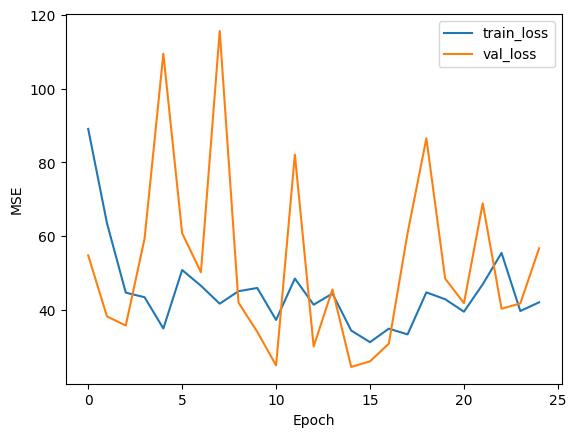

In [15]:
# Step 4a: Train the Model (baseline)
train_size = len(trainBL_loader.dataset)
steps_per_epoch = math.ceil(train_size / batch_size)
print("Train samples:", train_size)
print("Batch size:", batch_size)
print("Batches/epoch:", steps_per_epoch)

model.train()
num_epochs = 100 # max
patience = 10
best_val = float('inf')
no_improve = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # --- train ---
    model.train()
    running_loss = 0.0
    for X_batch, Y_batch in trainBL_loader:
        # Forward pass
        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_train_loss = running_loss / train_size
    train_losses.append(epoch_train_loss)

    # --- validate ---
    model.eval()
    val_running = 0.0
    with torch.no_grad():
        for X_val, Y_val in testBL_loader:   # use test_loader or a separate val_loader
            Y_val_pred = model(X_val)
            l = criterion(Y_val_pred, Y_val)
            val_running += l.item() * X_val.size(0)
    epoch_val_loss = val_running / len(testBL_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} — train_loss: {epoch_train_loss:.6f}, val_loss: {epoch_val_loss:.6f}")

    # --- Early stopping ---
    if epoch_val_loss < best_val - 1e-9:
        best_val = epoch_val_loss
        no_improve = 0
        # Optionally save best model:
        # torch.save(model.state_dict(), "neural_network_pytorch.pth")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"No improvement for {patience} epochs — stopping early at epoch {epoch+1}.")
            break

# After loop: plot train/val loss to inspect convergence
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

Train samples: 299997
Batch size: 64
Batches/epoch: 4688
Epoch 1/100 — train_loss: 5.321672, val_loss: 3.204328
Epoch 2/100 — train_loss: 3.371692, val_loss: 2.490934
Epoch 3/100 — train_loss: 3.009975, val_loss: 2.295781
Epoch 4/100 — train_loss: 2.767127, val_loss: 2.205539
Epoch 5/100 — train_loss: 2.661406, val_loss: 2.062436
Epoch 6/100 — train_loss: 2.613099, val_loss: 2.024573
Epoch 7/100 — train_loss: 2.531205, val_loss: 1.956831
Epoch 8/100 — train_loss: 2.461478, val_loss: 1.862191
Epoch 9/100 — train_loss: 2.376484, val_loss: 1.808293
Epoch 10/100 — train_loss: 2.459707, val_loss: 1.826385
Epoch 11/100 — train_loss: 2.257319, val_loss: 1.890222
Epoch 12/100 — train_loss: 2.240518, val_loss: 1.777242
Epoch 13/100 — train_loss: 2.332100, val_loss: 1.668777
Epoch 14/100 — train_loss: 2.190660, val_loss: 1.644308
Epoch 15/100 — train_loss: 2.143427, val_loss: 1.656359
Epoch 16/100 — train_loss: 2.125563, val_loss: 1.677815
Epoch 17/100 — train_loss: 2.120504, val_loss: 1.621171


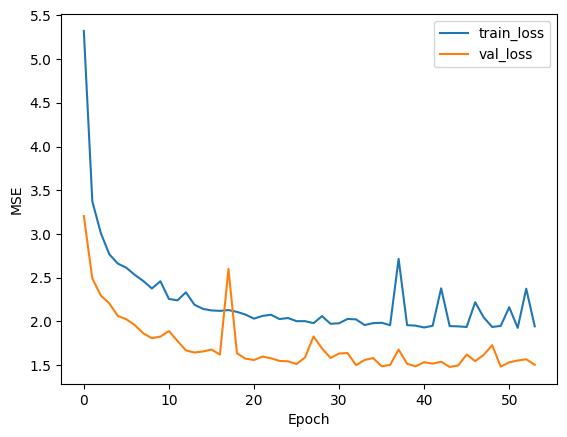

In [7]:
# Step 4b: Train the Model
train_size = len(train_loader.dataset)
steps_per_epoch = math.ceil(train_size / batch_size)
print("Train samples:", train_size)
print("Batch size:", batch_size)
print("Batches/epoch:", steps_per_epoch)

model.train()
num_epochs = 100 # max
patience = 10
best_val = float('inf')
no_improve = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # --- train ---
    model.train()
    running_loss = 0.0
    for X_batch, Y_batch in train_loader:
        # Forward pass
        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_train_loss = running_loss / train_size
    train_losses.append(epoch_train_loss)

    # --- validate ---
    model.eval()
    val_running = 0.0
    with torch.no_grad():
        for X_val, Y_val in test_loader:   # use test_loader or a separate val_loader
            Y_val_pred = model(X_val)
            l = criterion(Y_val_pred, Y_val)
            val_running += l.item() * X_val.size(0)
    epoch_val_loss = val_running / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} — train_loss: {epoch_train_loss:.6f}, val_loss: {epoch_val_loss:.6f}")

    # --- Early stopping ---
    if epoch_val_loss < best_val - 1e-9:
        best_val = epoch_val_loss
        no_improve = 0
        # Optionally save best model:
        # torch.save(model.state_dict(), "neural_network_pytorch.pth")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"No improvement for {patience} epochs — stopping early at epoch {epoch+1}.")
            break

# After loop: plot train/val loss to inspect convergence
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
# load best model
# model.load_state_dict(torch.load("neural_network_pytorch.pth"))

Test Loss: 5.3793


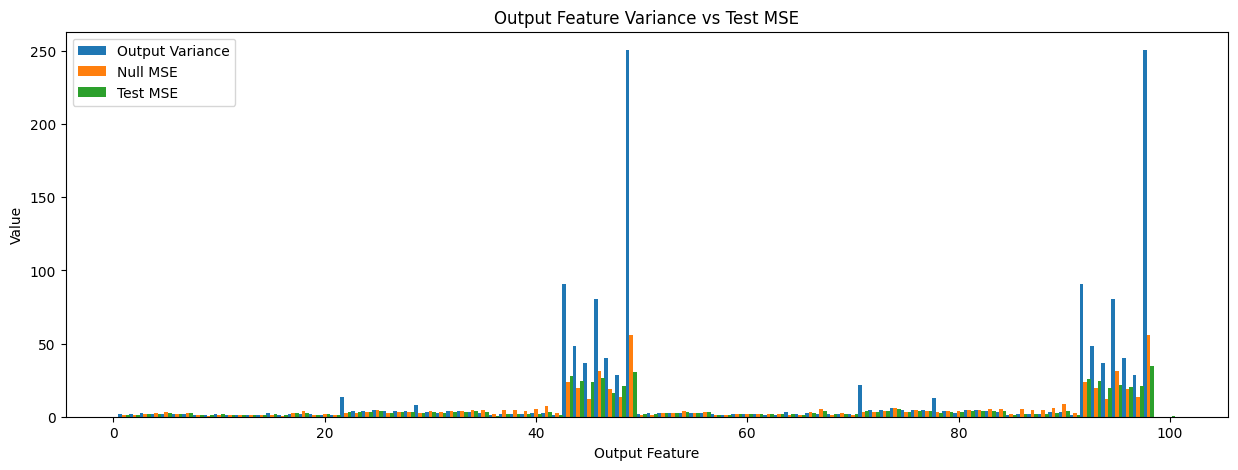

In [17]:
# Step 5: Evaluate the Model on Test Data
model.eval()
with torch.no_grad():
    total_loss = 0
    for X_batch, Y_batch in test_loader:
        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch)
        total_loss += loss.item() * X_batch.size(0)  # sum up batch loss

    avg_loss = total_loss / len(test_dataset)
    print(f"Test Loss: {avg_loss:.4f}")

Y_test_np = Y_test.numpy()
with torch.no_grad():
    Y_pred_np = model(X_test).numpy()

X_all_np = X.numpy()
Y_all_np = Y.numpy()
with torch.no_grad():
    Y_pred_all_np = model(X).numpy()

Y_null_all_np = X.numpy()[:, :Y.shape[1]]
Y_null_test_np = X_test.numpy()[:, :Y.shape[1]]

MSE_per_feat = np.mean((Y_test_np - Y_pred_np) ** 2, axis=0)
MSE_per_feat_null = np.mean((Y_test_np - Y_null_test_np) ** 2, axis=0)
feats = np.arange(1, Y.shape[1]+1)
barwid = .35

plt.figure(figsize=(15,5))
plt.bar(feats - barwid, var_per_feat, width=barwid, label='Output Variance')
plt.bar(feats, MSE_per_feat_null, width=barwid, label='Null MSE')
plt.bar(feats + barwid, MSE_per_feat, width=barwid, label='Test MSE')
plt.xlabel('Output Feature')
plt.ylabel('Value')
plt.title('Output Feature Variance vs Test MSE')
plt.legend()
plt.show()

In [16]:
model.eval()
with torch.no_grad():
    total_loss = 0
    for X_batch, Y_batch in testBL_loader:
        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch)
        total_loss += loss.item() * X_batch.size(0)  # sum up batch loss

    avg_loss = total_loss / len(test_dataset)
    print(f"Test Loss: {avg_loss:.4f}")

Test Loss: 544.6473


In [18]:
# simulations 
simdur = int(0.2 * fs) # samples 
plotdomain = 1000 * np.array([-1, 1]) + train_N

Ysim = []
i0 = plotdomain[0]
model.eval()
while i0+simdur < plotdomain[1]:
    xi = torch.tensor(X_all_np[i0, :].reshape(1, -1), dtype=torch.float32)
    for i in range(simdur):
        with torch.no_grad():
            yi = model(xi).numpy().flatten()
        Ysim.append(yi)
        # prepare next input
        if i < simdur - 1:
            event_count_next = X_all_np[i0 + i + 1, -1]  # keep using original event count
            xi = torch.tensor(np.hstack([yi, event_count_next]).reshape(1, -1), dtype=torch.float32)
    i0 += simdur
    print("Simulating:", (i0-plotdomain[0])/(plotdomain[1]-plotdomain[0]), " complete." )

Ysim = np.array(Ysim)
plotxval = np.arange(len(Ysim)) + plotdomain[0]

Simulating: 0.1  complete.
Simulating: 0.2  complete.
Simulating: 0.3  complete.
Simulating: 0.4  complete.
Simulating: 0.5  complete.
Simulating: 0.6  complete.
Simulating: 0.7  complete.
Simulating: 0.8  complete.
Simulating: 0.9  complete.


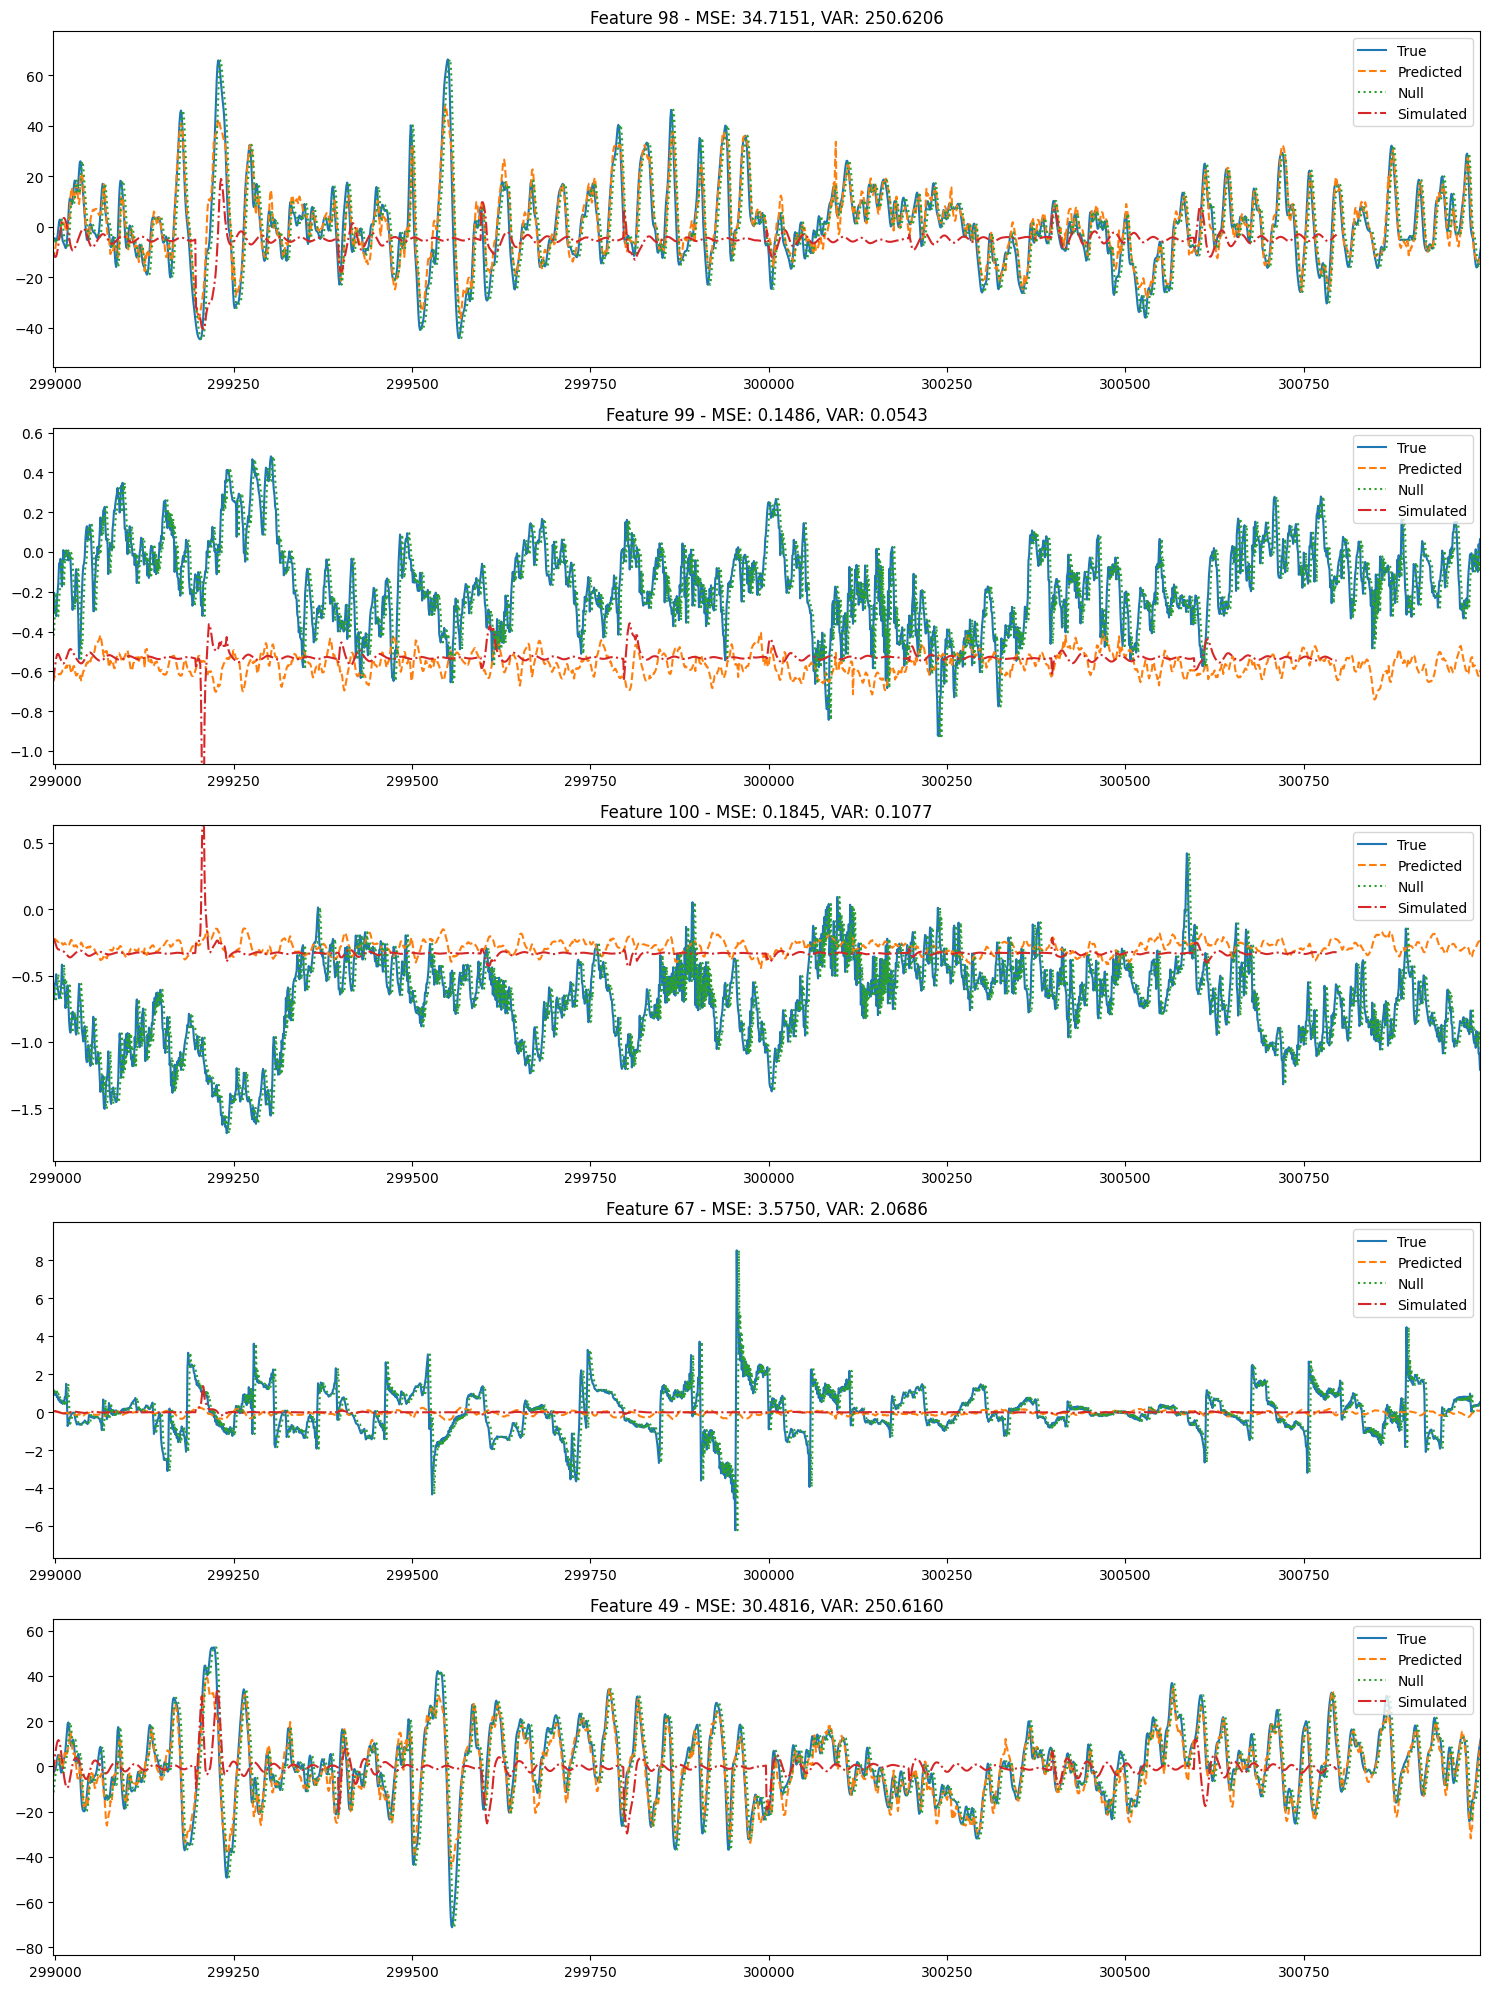

In [19]:
# show several examples 

iMSE = np.argsort(MSE_per_feat)
iVAR = np.argsort(var_per_feat)
iLRN = np.argsort(MSE_per_feat / var_per_feat)
iToPlot = [iMSE[:2], iMSE[-2:], iVAR[:2], iVAR[-2:], iLRN[:2], iLRN[-2:]]
iToPlot = list(set([i for sublist in iToPlot for i in sublist]))

plt.figure(figsize=(15,20))
iPlot = 1
for i in iToPlot:
    plt.subplot(len(iToPlot), 1, iPlot)
    plt.plot(Y_all_np[:, i], label='True')
    plt.plot(Y_pred_all_np[:, i], label='Predicted', linestyle='--')
    plt.plot(Y_null_all_np[:, i], label='Null', linestyle=':')
    plt.plot(plotxval, Ysim[:,i], label='Simulated', linestyle='-.')
    plt.xlim(plotdomain)

    # set the y limits to be slightly larger than the min/max of true values in the plotdomain
    y_min = np.min(Y_all_np[plotdomain[0]:plotdomain[1], i])
    y_max = np.max(Y_all_np[plotdomain[0]:plotdomain[1], i])
    y_range = y_max - y_min
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
    
    plt.title(f'Feature {i+1} - MSE: {MSE_per_feat[i]:.4f}, VAR: {var_per_feat[i]:.4f}')
    plt.legend(loc='upper right')
    iPlot += 1
plt.tight_layout()
plt.show()

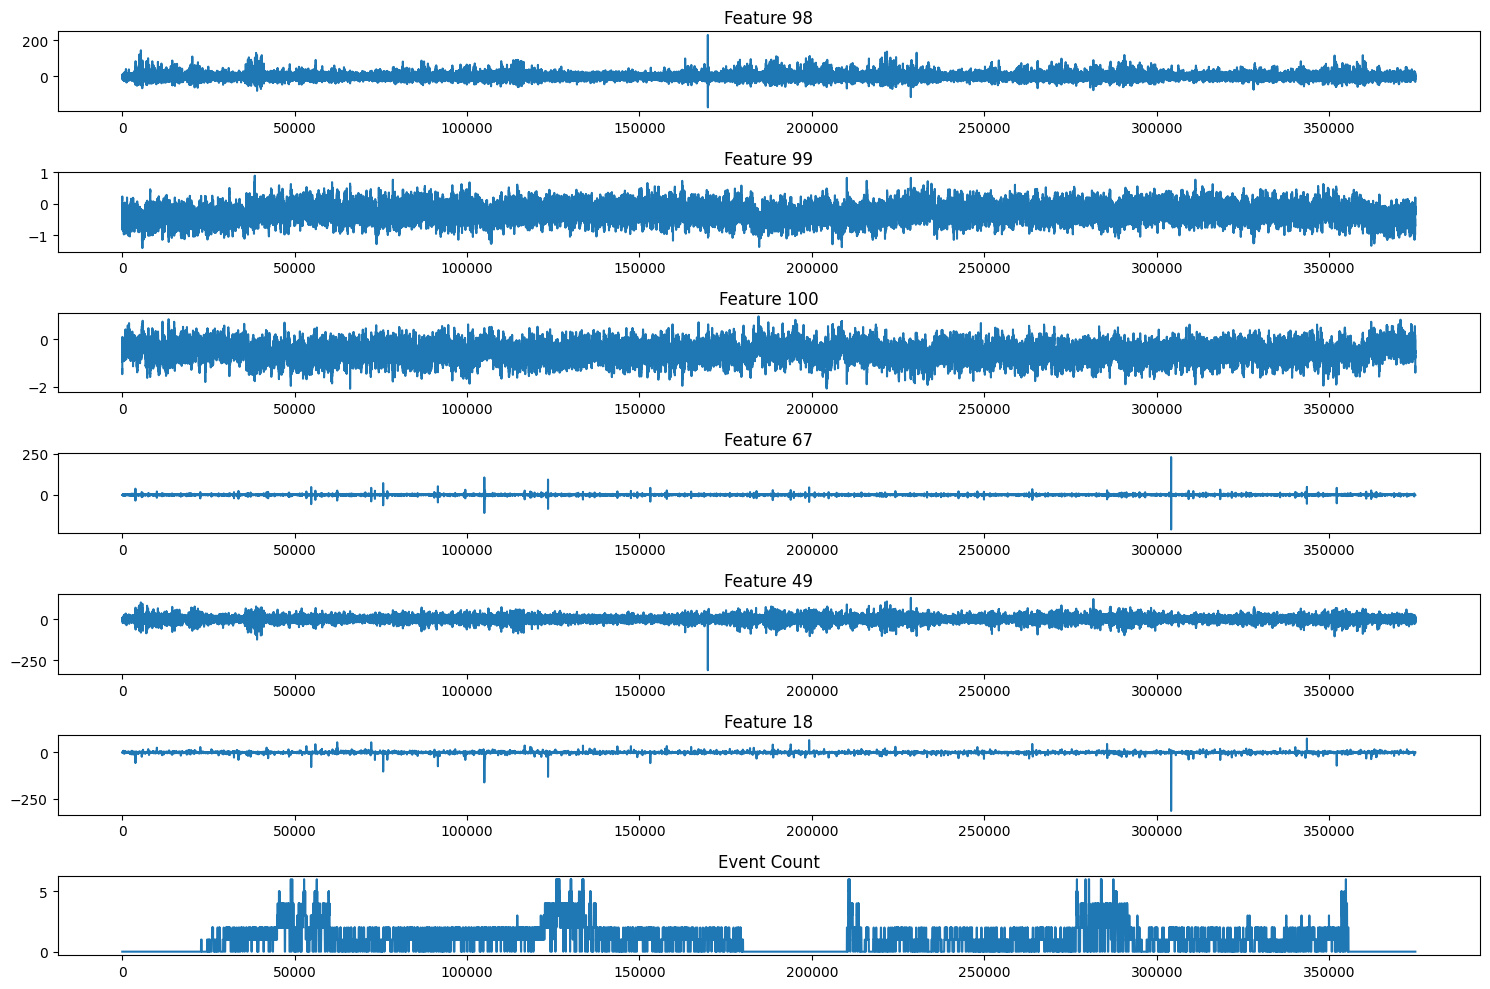

In [13]:
# plot columns iToPlot of Y and YBL
plt.figure(figsize=(15,10))
iPlot = 1
for i in iToPlot:
    plt.subplot(len(iToPlot)+1, 1, iPlot)
    plt.plot(Y[:, i], label='True BL')
    
    plt.title(f'Feature {i+1}')
    iPlot += 1

plt.subplot(len(iToPlot)+1, 1, iPlot)
plt.plot(X[:, -1], label='Event Count')
plt.title('Event Count')

plt.tight_layout()
plt.show()

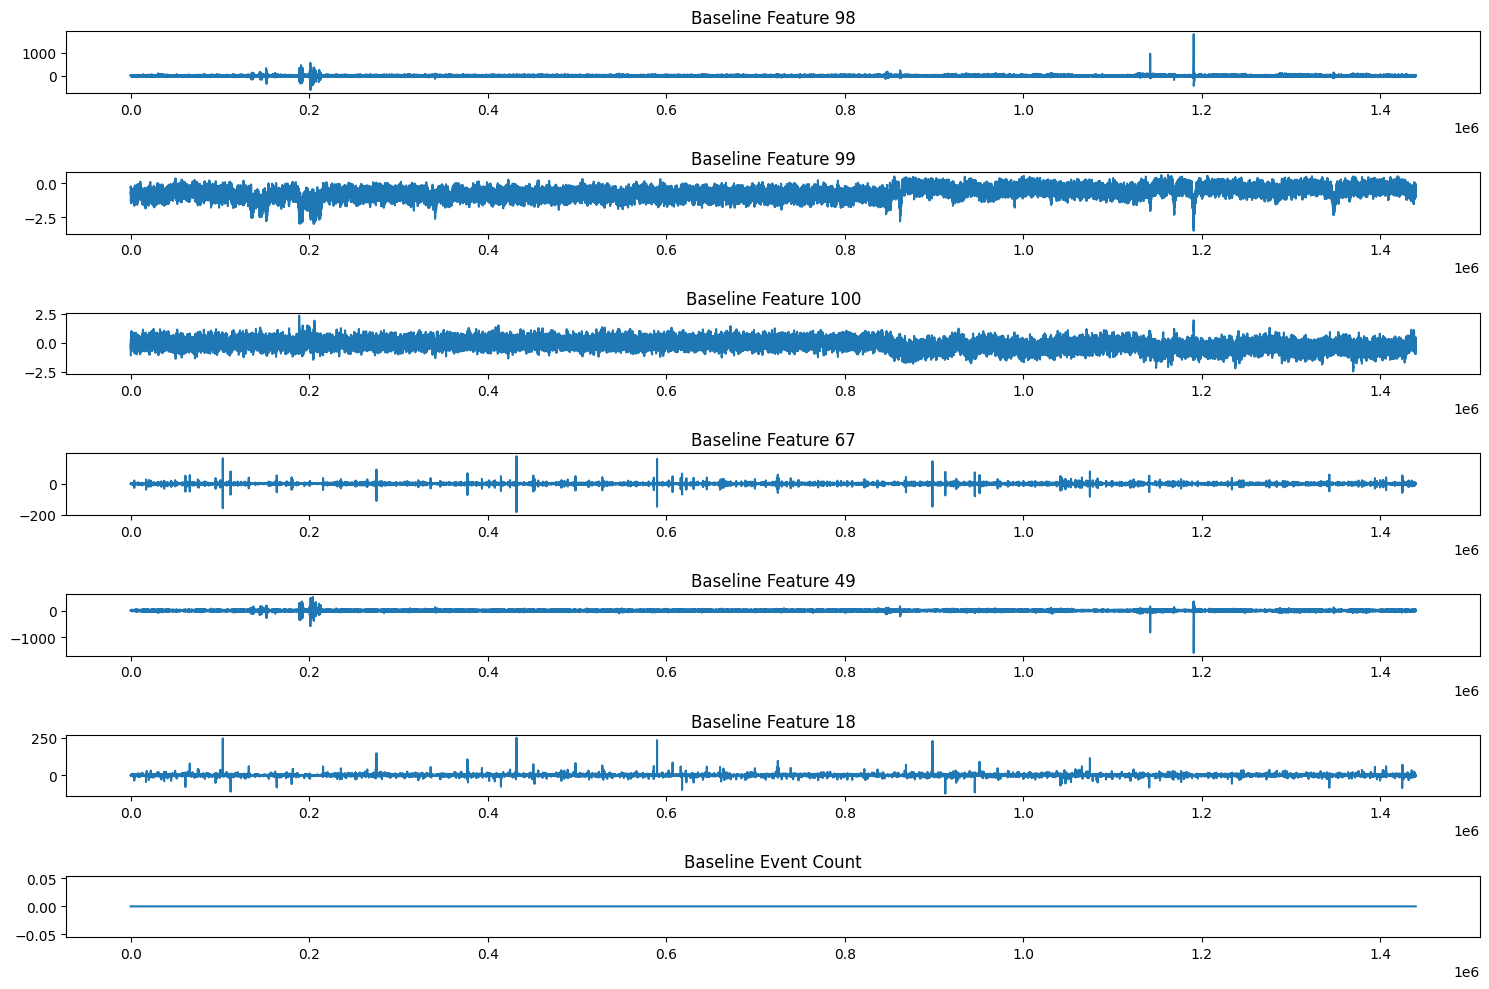

In [14]:
# plot columns iToPlot of Y and YBL
plt.figure(figsize=(15,10))
iPlot = 1
for i in iToPlot:
    plt.subplot(len(iToPlot)+1, 1, iPlot)
    plt.plot(YBL[:, i], label='True BL')
    
    plt.title(f'Baseline Feature {i+1}')
    iPlot += 1


plt.subplot(len(iToPlot)+1, 1, iPlot)
plt.plot(XBL[:, -1], label='Event Count')
plt.title('Baseline Event Count')

plt.tight_layout()
plt.show()